In [ ]:
결측치 모두 제거
unitprice * quantity = amount_spent 변수 생성
year,mon,day,hour 나눠서 생성
Recency 변수 생성. 최근 주문에 관련된 변수. # retail_uk['InvoiceDate'].max()
Frequency 변수 생성. 유저별 distinct 주문 번호.
----------------------------------------
EDA
- 

----------------------------------------
고객 클러스터링 : 재구매율, 평균 구매 단가, 총 구매량, 총 구매금액, 총 구매 아이템 종류, 
              재방문 구매 일수(distinct day), 구매 평균 텀(주문번호 간의 시간간격의 평균)
    --> 표준화 해야됨!
    --> 2차원으로 시각화 한번 하고, 다차원으로 분류. 다차원도 t-sne 시도해볼것.
    --> 여러 조합중 제일 좋은 방법만 주피터에 남겨놓기 (+ 변수 선택 기법도 공부해서 넣기)
    
클러스터별 키워드 추출해서 워드 클라우드
----------------------------------------

장바구니 연관분석 시행
----------------------------------------
1. customer id 입력하면 고객 세그 id 출력 및 세그 선호 키워드 시각화
2. stockcode 입력하면 관련 상품 리스트 출력

In [ ]:
1. 탐색적 데이터 분석
    데이터 기초 정보
    각종 EDA
2. 행동 패턴으로 군집 분류하기
    간단한 kmeans 군집분류
        엘보우 메서드
    다차원 군집 분류
        데이터 전처리 : 표준화
        엘보우 메서드 + 변수 선택
        t-sne
3. 군집별 데이터 분석하기
    군집별 키워드 탐색
    군집별 장바구니 분석

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Actual transactions from UK retailer
df = pd.read_csv("../data/online_retail.csv", dtype={'CustomerID': str,'InvoiceID': str}, encoding="ISO-8859-1")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%m/%d/%Y %H:%M")

In [3]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df.shape

(541909, 8)

In [6]:
df = df.dropna()

In [7]:
df.shape

(406829, 8)

In [8]:
print("The number of total order :", len(df['InvoiceNo'].unique()))
print("The number of item :", len(df['StockCode'].unique()))
print("The number of customer :", len(df['CustomerID'].unique()))
print("The number of country :", len(df['Country'].unique()))

The number of total order : 22190
The number of item : 3684
The number of customer : 4372
The number of country : 37


Country
United Kingdom    361878
Germany             9495
France              8491
EIRE                7485
Spain               2533
Name: InvoiceNo, dtype: int64


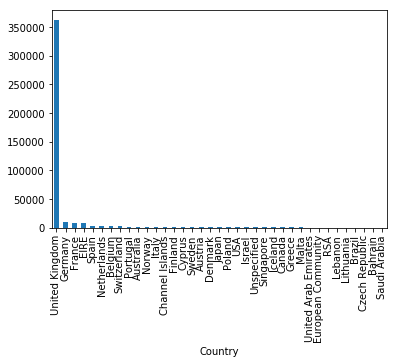

In [9]:
country_rank = df.groupby('Country')['InvoiceNo'].count().sort_values(ascending=False)
print(country_rank[:5])
country_rank.plot.bar()

In [10]:
print(df['Quantity'].value_counts()[:15])

 1     73314
 12    60033
 2     58003
 6     37688
 4     32183
 3     26948
 24    23751
 10    21213
 8     11644
 5      8150
 48     5988
 25     4995
 20     4766
 16     3946
-1      3848
Name: Quantity, dtype: int64


In [11]:
print(len(df[df['Quantity'] < 0]))

8905


In [12]:
df = df[df['Quantity'] > 0]
print(df.shape)

(397924, 8)


count    397924.000000
mean          3.116174
std          22.096788
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64


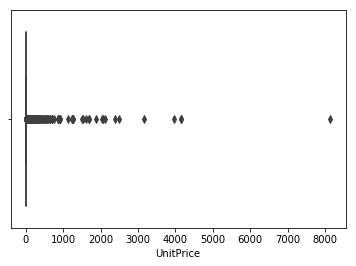

In [13]:
print(df['UnitPrice'].describe())
sns.boxplot(df['UnitPrice'])

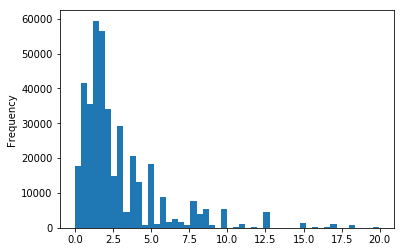

In [14]:
df[df['UnitPrice'] < 20]['UnitPrice'].plot(kind='hist', bins=50)

In [15]:
df['CustomerOrderCount'] = df.groupby('CustomerID')['InvoiceNo'].transform(lambda x: x.nunique())
df['CustomerItemCount'] = df.groupby('CustomerID')['StockCode'].transform(lambda x: x.nunique())

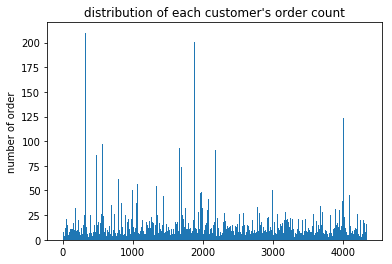

In [16]:
orders = df.groupby('CustomerID')['CustomerOrderCount'].first()

plt.bar(range(len(orders)), orders.values, width=10)
plt.ylabel('number of order')
plt.title("distribution of each customer's order count")
plt.show()

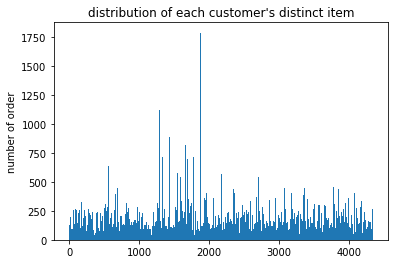

In [17]:
orders = df.groupby('CustomerID')['CustomerItemCount'].first()

plt.bar(range(len(orders)), orders.values, width=10)
plt.ylabel('number of order')
plt.title("distribution of each customer's distinct item")
plt.show()

In [18]:
df['Amount'] = df['Quantity'] * df['UnitPrice']
df['YearMonDay'] = df['InvoiceDate'].apply(lambda x: str(x)[:10])
df['Year'] = pd.DatetimeIndex(df['InvoiceDate']).year
df['Mon'] = pd.DatetimeIndex(df['InvoiceDate']).month
df['Day'] = pd.DatetimeIndex(df['InvoiceDate']).day
df['Hour'] = pd.DatetimeIndex(df['InvoiceDate']).hour
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerOrderCount,CustomerItemCount,Amount,YearMonDay,Year,Mon,Day,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,34,21,15.30,2010-12-01,2010,12,1,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,34,21,20.34,2010-12-01,2010,12,1,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,34,21,22.00,2010-12-01,2010,12,1,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,34,21,20.34,2010-12-01,2010,12,1,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,34,21,20.34,2010-12-01,2010,12,1,8


In [19]:
df['CustomerTotalAmount'] = df.groupby('CustomerID')['Amount'].transform(lambda x: x.sum())
df['CustomerAverageAmount'] = df['CustomerTotalAmount'] / df['CustomerOrderCount']

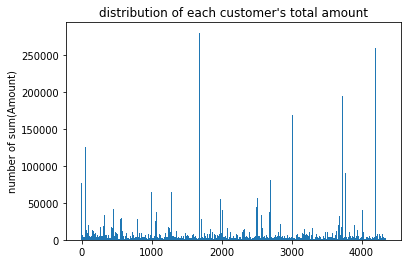

In [20]:
orders = df.groupby('CustomerID')['CustomerTotalAmount'].first()

plt.bar(range(len(orders)), orders.values, width=10)
plt.ylabel('number of sum(Amount)')
plt.title("distribution of each customer's total amount")
plt.show()

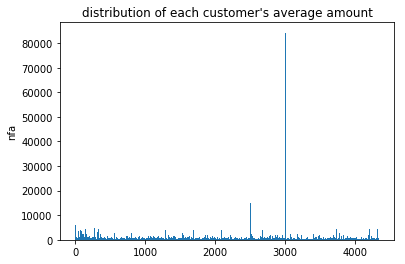

In [21]:
orders = df.groupby('CustomerID')['CustomerAverageAmount'].first()

plt.bar(range(len(orders)), orders.values, width=10)
plt.ylabel('nfa')
plt.title("distribution of each customer's average amount")
plt.show()

count    397924.000000
mean        553.797599
std         744.905807
min           0.000000
25%         236.395000
50%         362.688182
75%         567.520000
max       84236.250000
Name: CustomerAverageAmount, dtype: float64


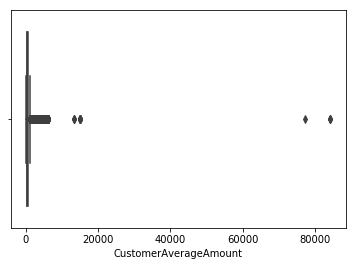

In [22]:
print(df['CustomerAverageAmount'].describe())
sns.boxplot(df['CustomerAverageAmount'])

In [23]:
print(df['Year'].value_counts())
print(df['Mon'].value_counts())

2011    371764
2010     26160
Name: Year, dtype: int64
11    64545
10    49557
12    43464
9     40030
5     28322
6     27185
3     27177
8     27013
7     26827
4     22644
1     21232
2     19928
Name: Mon, dtype: int64


2010-12-01 08:26:00
2011-12-09 12:50:00


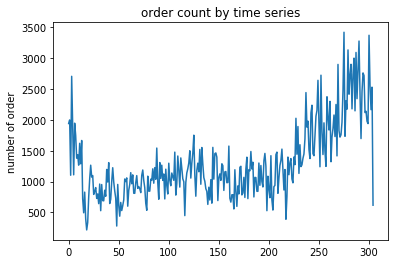

In [24]:
print(df['InvoiceDate'].min())
print(df['InvoiceDate'].max())

orders = df.groupby(['Year', 'Mon', 'Day'])['InvoiceNo'].count()
plt.plot(range(len(orders)), orders.values)
plt.ylabel('number of order')
plt.title("order count by time series")
plt.show()

In [25]:
df['OrderDateCount'] = df.groupby('CustomerID')['YearMonDay'].transform(lambda x: x.nunique())

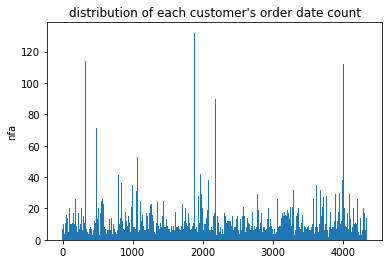

In [26]:
orders = df.groupby('CustomerID')['OrderDateCount'].first()

plt.bar(range(len(orders)), orders.values, width=10)
plt.ylabel('nfa')
plt.title("distribution of each customer's order date count")
plt.show()

In [27]:
customer_order_date_set = df.groupby('CustomerID')['InvoiceDate'].apply(set)
print(customer_order_date_set[:10])

CustomerID
12346                                {2011-01-18 10:01:00}
12347    {2011-01-26 14:30:00, 2011-04-07 10:43:00, 201...
12348    {2010-12-16 19:09:00, 2011-01-25 10:42:00, 201...
12349                                {2011-11-21 09:51:00}
12350                                {2011-02-02 16:01:00}
12352    {2011-03-17 16:00:00, 2011-03-01 14:57:00, 201...
12353                                {2011-05-19 17:47:00}
12354                                {2011-04-21 13:11:00}
12355                                {2011-05-09 13:49:00}
12356    {2011-04-08 12:33:00, 2011-11-17 08:40:00, 201...
Name: InvoiceDate, dtype: object


In [28]:
cust_order_term_dict = {}
recent = df['InvoiceDate'].max()
for cust_no, date_set in customer_order_date_set.items():
    if len(date_set) == 1:
        date = date_set.pop()
        term = pd.Timedelta(recent - date).days
        cust_order_term_dict[cust_no] = term
    else:
        sorted_date_set = list(sorted(date_set))
        avg_term = 0
        prev_date = sorted_date_set[0]
        for date in sorted_date_set[1:]:
            term = pd.Timedelta(date - prev_date).days
            avg_term += term
            prev_date = date
        cust_order_term_dict[cust_no] = avg_term

In [29]:
cust_order_term_dict

{'12346': 325,
 '12347': 362,
 '12348': 282,
 '12349': 18,
 '12350': 309,
 '12352': 258,
 '12353': 203,
 '12354': 231,
 '12355': 213,
 '12356': 302,
 '12357': 32,
 '12358': 149,
 '12359': 273,
 '12360': 148,
 '12361': 286,
 '12362': 287,
 '12363': 132,
 '12364': 103,
 '12365': 0,
 '12367': 3,
 '12370': 308,
 '12371': 14,
 '12372': 224,
 '12373': 310,
 '12374': 24,
 '12375': 87,
 '12377': 39,
 '12378': 129,
 '12379': 88,
 '12380': 162,
 '12381': 113,
 '12383': 165,
 '12384': 92,
 '12386': 29,
 '12388': 309,
 '12390': 79,
 '12391': 21,
 '12393': 259,
 '12394': 153,
 '12395': 346,
 '12397': 99,
 '12398': 45,
 '12399': 142,
 '12401': 302,
 '12402': 322,
 '12403': 49,
 '12405': 148,
 '12406': 161,
 '12407': 212,
 '12408': 226,
 '12409': 103,
 '12410': 0,
 '12412': 93,
 '12413': 269,
 '12414': 92,
 '12415': 303,
 '12417': 350,
 '12418': 112,
 '12420': 63,
 '12421': 301,
 '12422': 228,
 '12423': 349,
 '12424': 162,
 '12425': 77,
 '12426': 194,
 '12427': 349,
 '12428': 255,
 '12429': 355,
 '12

In [30]:
df['AverageOrderDateTerm'] = df['CustomerID'].apply(lambda x: cust_order_term_dict[x])

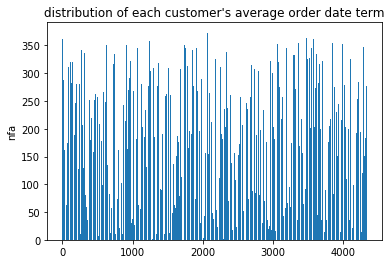

In [31]:
orders = df.groupby('CustomerID')['AverageOrderDateTerm'].first()

plt.bar(range(len(orders)), orders.values)
plt.ylabel('nfa')
plt.title("distribution of each customer's average order date term")
plt.show()

In [32]:
def get_reorder_rate(x):
    customer_dict = x.value_counts()
    stock_len = len(customer_dict)
    reorder_stock_len = 0
    reorder_stock_len = len(customer_dict[customer_dict > 1])
    return reorder_stock_len/stock_len
df['CustomerReorderStockRate'] = df.groupby('CustomerID')['StockCode'].transform(lambda x: get_reorder_rate(x))

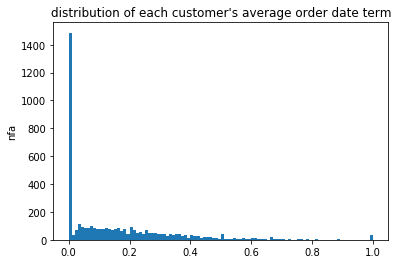

In [33]:
orders = df.groupby('CustomerID')['CustomerReorderStockRate'].first()

plt.hist(orders.values, bins=100)
plt.ylabel('nfa')
plt.title("distribution of each customer's average order date term")
plt.show()

In [34]:
df = df.sort_values(['CustomerID', 'StockCode', 'InvoiceDate'])
df_shift = df.shift(1)
df['Reorder'] = np.where((df['StockCode'] == df_shift['StockCode']) & (df['CustomerID'] == df_shift['CustomerID']), 1,0)

In [35]:
df['CustomerReorderTransactionRate'] = df.groupby('CustomerID')['Reorder'].transform(np.mean)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerOrderCount,CustomerItemCount,...,Mon,Day,Hour,CustomerTotalAmount,CustomerAverageAmount,OrderDateCount,AverageOrderDateTerm,CustomerReorderStockRate,Reorder,CustomerReorderTransactionRate
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,1,1,...,1,18,10,77183.6,77183.600000,1,325,0.000000,0,0.000000
148306,549222,16008,SMALL FOLDING SCISSOR(POINTED EDGE),24,2011-04-07 10:43:00,0.25,12347,Iceland,7,103,...,4,7,10,4310.0,615.714286,7,362,0.417476,0,0.434066
220583,556201,17021,NAMASTE SWAGAT INCENSE,36,2011-06-09 13:01:00,0.30,12347,Iceland,7,103,...,6,9,13,4310.0,615.714286,7,362,0.417476,0,0.434066
148289,549222,20665,RED RETROSPOT PURSE,6,2011-04-07 10:43:00,2.95,12347,Iceland,7,103,...,4,7,10,4310.0,615.714286,7,362,0.417476,0,0.434066
72249,542237,20719,WOODLAND CHARLOTTE BAG,10,2011-01-26 14:30:00,0.85,12347,Iceland,7,103,...,1,26,14,4310.0,615.714286,7,362,0.417476,0,0.434066


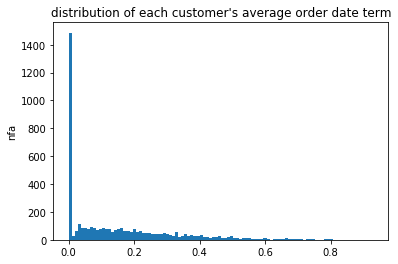

In [36]:
orders = df.groupby('CustomerID')['CustomerReorderTransactionRate'].first()

plt.hist(orders.values, bins=100)
plt.ylabel('nfa')
plt.title("distribution of each customer's average order date term")
plt.show()

# 정규화

In [37]:
customer_profile_df = df.copy()

In [38]:
customer_profile_df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'CustomerOrderCount',
       'CustomerItemCount', 'Amount', 'YearMonDay', 'Year', 'Mon', 'Day',
       'Hour', 'CustomerTotalAmount', 'CustomerAverageAmount',
       'OrderDateCount', 'AverageOrderDateTerm', 'CustomerReorderStockRate',
       'Reorder', 'CustomerReorderTransactionRate'],
      dtype='object')

In [39]:
customer_profile_df = customer_profile_df[['CustomerID', 'CustomerOrderCount',
                                           'CustomerItemCount',
                                           'CustomerTotalAmount', 'CustomerAverageAmount',
                                           'OrderDateCount', 'AverageOrderDateTerm', 
                                           'CustomerReorderStockRate', 'CustomerReorderTransactionRate']]
customer_profile_df.head()

,CustomerID,CustomerOrderCount,CustomerItemCount,CustomerTotalAmount,CustomerAverageAmount,OrderDateCount,AverageOrderDateTerm,CustomerReorderStockRate,CustomerReorderTransactionRate
61619,12346,1,1,77183.6,77183.600000,1,325,0.000000,0.000000
148306,12347,7,103,4310.0,615.714286,7,362,0.417476,0.434066
220583,12347,7,103,4310.0,615.714286,7,362,0.417476,0.434066
148289,12347,7,103,4310.0,615.714286,7,362,0.417476,0.434066
72249,12347,7,103,4310.0,615.714286,7,362,0.417476,0.434066


In [40]:
customer_profile_df = customer_profile_df.drop_duplicates('CustomerID')

In [41]:
customer_profile_df.head()

,CustomerID,CustomerOrderCount,CustomerItemCount,CustomerTotalAmount,CustomerAverageAmount,OrderDateCount,AverageOrderDateTerm,CustomerReorderStockRate,CustomerReorderTransactionRate
61619,12346,1,1,77183.60,77183.600000,1,325,0.000000,0.000000
148306,12347,7,103,4310.00,615.714286,7,362,0.417476,0.434066
34093,12348,4,22,1797.24,449.310000,4,282,0.318182,0.290323
485527,12349,1,73,1757.55,1757.550000,1,18,0.000000,0.000000
80339,12350,1,17,334.40,334.400000,1,309,0.000000,0.000000


In [42]:
def minmax_scaling(df, scale_columns):
    for col in scale_columns:
        series_min = df[col].min()
        series_max = df[col].max()
        df[col] = df[col].apply(lambda x: (x - series_min)/(series_max - series_min))
    return df

In [43]:
scale_columns = ['CustomerOrderCount',
                 'CustomerItemCount',
                 'CustomerTotalAmount', 'CustomerAverageAmount',
                 'OrderDateCount', 'AverageOrderDateTerm', 
                 'CustomerReorderStockRate', 'CustomerReorderTransactionRate']
scaled_customer_profile_df = minmax_scaling(customer_profile_df, scale_columns)

In [44]:
scaled_customer_profile_df.head()

,CustomerID,CustomerOrderCount,CustomerItemCount,CustomerTotalAmount,CustomerAverageAmount,OrderDateCount,AverageOrderDateTerm,CustomerReorderStockRate,CustomerReorderTransactionRate
61619,12346,0.000000,0.000000,0.275453,0.916275,0.000000,0.871314,0.000000,0.000000
148306,12347,0.028708,0.057111,0.015382,0.007309,0.045802,0.970509,0.417476,0.467093
34093,12348,0.014354,0.011758,0.006414,0.005334,0.022901,0.756032,0.318182,0.312412
485527,12349,0.000000,0.040314,0.006272,0.020865,0.000000,0.048257,0.000000,0.000000
80339,12350,0.000000,0.008959,0.001193,0.003970,0.000000,0.828418,0.000000,0.000000


# 클러스터링

- 사람이 이해 가능한 수준
- 사람이 이해 불가능한 수준

In [45]:
from sklearn.cluster import KMeans

X = scaled_customer_profile_df[['CustomerOrderCount', 'CustomerTotalAmount']]

In [46]:
k_list = []
cost_list = []
for k in range (1, 10):
    kmeans = KMeans(n_clusters=k).fit(X)
    interia = kmeans.inertia_
    print ("k:", k, "| cost:", interia)
    k_list.append(k)
    cost_list.append(interia)

k: 1 | cost: 10.360142338330316
k: 2 | cost: 5.6843840821270275
k: 3 | cost: 3.93605240427797
k: 4 | cost: 2.7526129463941063
k: 5 | cost: 1.9747804037117251
k: 6 | cost: 1.53032790739304
k: 7 | cost: 1.1994079387932108
k: 8 | cost: 1.017064210064038
k: 9 | cost: 0.8450012562987098


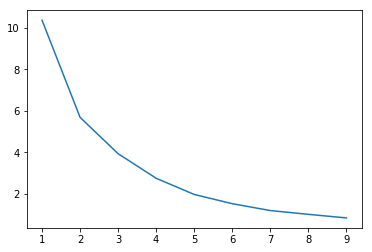

In [47]:
plt.plot(k_list, cost_list)

In [48]:
kmeans = KMeans(n_clusters=4).fit(X)
cluster_num = kmeans.predict(X)
cluster = pd.Series(cluster_num)
scaled_customer_profile_df['cluster_num'] = cluster.values

In [49]:
scaled_customer_profile_df.head()

,CustomerID,CustomerOrderCount,CustomerItemCount,CustomerTotalAmount,CustomerAverageAmount,OrderDateCount,AverageOrderDateTerm,CustomerReorderStockRate,CustomerReorderTransactionRate,cluster_num
61619,12346,0.000000,0.000000,0.275453,0.916275,0.000000,0.871314,0.000000,0.000000,2
148306,12347,0.028708,0.057111,0.015382,0.007309,0.045802,0.970509,0.417476,0.467093,0
34093,12348,0.014354,0.011758,0.006414,0.005334,0.022901,0.756032,0.318182,0.312412,0
485527,12349,0.000000,0.040314,0.006272,0.020865,0.000000,0.048257,0.000000,0.000000,0
80339,12350,0.000000,0.008959,0.001193,0.003970,0.000000,0.828418,0.000000,0.000000,0


In [50]:
scaled_customer_profile_df['cluster_num'].value_counts()

0    4058
2     267
3       8
1       6
Name: cluster_num, dtype: int64

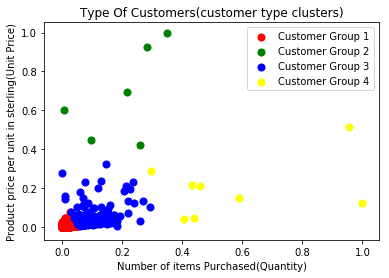

In [51]:
plt.scatter(scaled_customer_profile_df[scaled_customer_profile_df['cluster_num'] == 0]['CustomerOrderCount'], 
            scaled_customer_profile_df[scaled_customer_profile_df['cluster_num'] == 0]['CustomerTotalAmount'], 
            s = 50, c = 'red', label = 'Customer Group 1')
plt.scatter(scaled_customer_profile_df[scaled_customer_profile_df['cluster_num'] == 1]['CustomerOrderCount'], 
            scaled_customer_profile_df[scaled_customer_profile_df['cluster_num'] == 1]['CustomerTotalAmount'], 
            s = 50, c = 'green', label = 'Customer Group 2')
plt.scatter(scaled_customer_profile_df[scaled_customer_profile_df['cluster_num'] == 2]['CustomerOrderCount'], 
            scaled_customer_profile_df[scaled_customer_profile_df['cluster_num'] == 2]['CustomerTotalAmount'], 
            s = 50, c = 'blue', label = 'Customer Group 3')
plt.scatter(scaled_customer_profile_df[scaled_customer_profile_df['cluster_num'] == 3]['CustomerOrderCount'], 
            scaled_customer_profile_df[scaled_customer_profile_df['cluster_num'] == 3]['CustomerTotalAmount'], 
            s = 50, c = 'yellow', label = 'Customer Group 4')
plt.title('Type Of Customers(customer type clusters)')
plt.xlabel('Number of items Purchased(Quantity)')
plt.ylabel('Product price per unit in sterling(Unit Price)')
plt.legend()
plt.show()

# 다차원 클러스터링

k: 1 | cost: 755.8047794098561
k: 2 | cost: 400.7303890376667
k: 3 | cost: 252.22911836678145
k: 4 | cost: 205.17486261388638
k: 5 | cost: 170.59537351872925
k: 6 | cost: 142.01579242306053
k: 7 | cost: 124.5386996085939
k: 8 | cost: 109.79638952101317
k: 9 | cost: 99.90575098502651
k: 10 | cost: 92.25174948537408
k: 11 | cost: 84.18096890088296
k: 12 | cost: 77.99618122786974
k: 13 | cost: 72.25225872996256
k: 14 | cost: 67.62147304887178
k: 15 | cost: 63.27364103184552
k: 16 | cost: 60.191047687855146
k: 17 | cost: 57.69822740566943
k: 18 | cost: 55.18551464579113
k: 19 | cost: 53.2364686560508


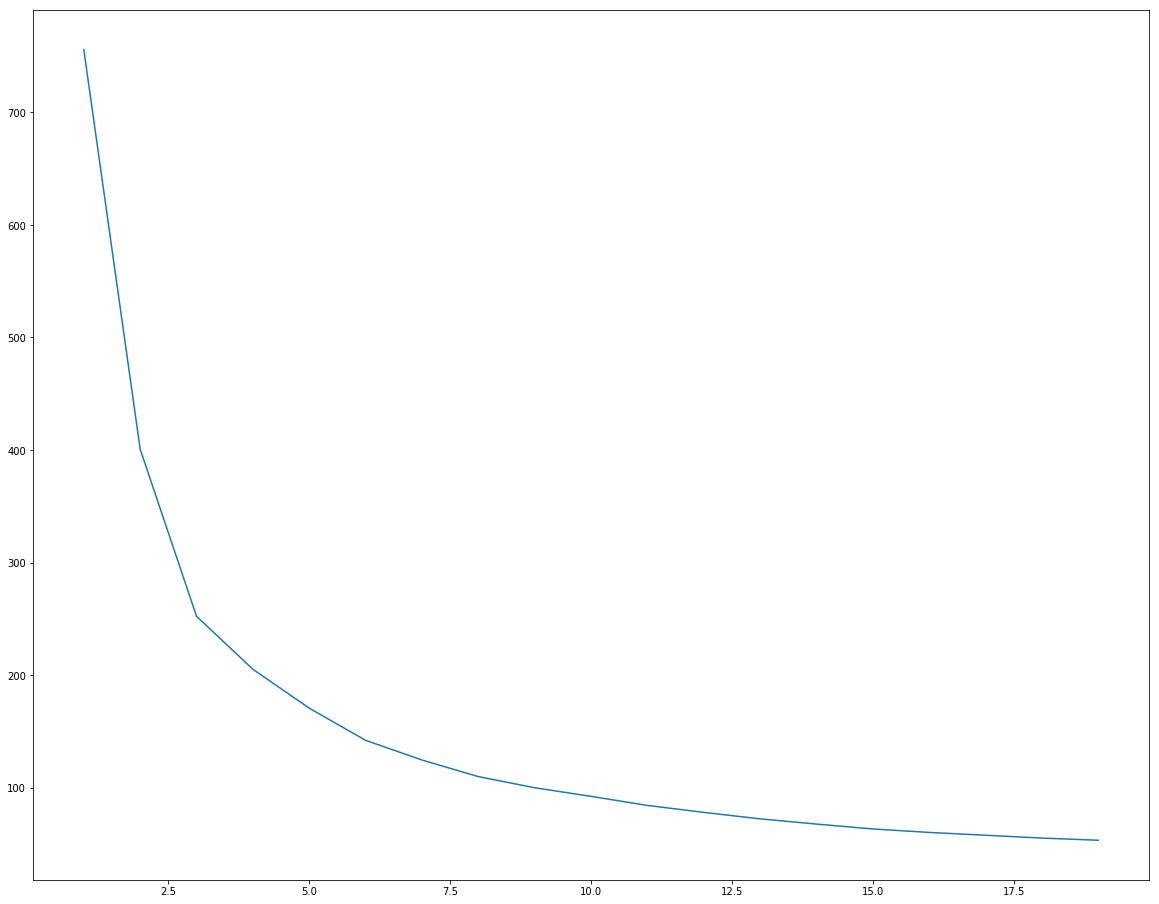

In [94]:
scale_columns = ['CustomerOrderCount',
                 'CustomerItemCount',
                 'CustomerTotalAmount', 
                 'CustomerAverageAmount', 'OrderDateCount', 'AverageOrderDateTerm', 
                 'CustomerReorderStockRate', 'CustomerReorderTransactionRate']

X = scaled_customer_profile_df[scale_columns]

k_list = []
cost_list = []
for k in range (1, 20):
    kmeans = KMeans(n_clusters=k).fit(X)
    interia = kmeans.inertia_
    print ("k:", k, "| cost:", interia)
    k_list.append(k)
    cost_list.append(interia)
plt.plot(k_list, cost_list)

k: 1 | cost: 331.02592143634024
k: 2 | cost: 116.56330894881066
k: 3 | cost: 66.0330077542964
k: 4 | cost: 45.87674490148363
k: 5 | cost: 36.890342587787856
k: 6 | cost: 31.44036817569239
k: 7 | cost: 26.25394879260952
k: 8 | cost: 23.22568670719631
k: 9 | cost: 21.302364500773816
k: 10 | cost: 19.714426819748187
k: 11 | cost: 18.54866423875307
k: 12 | cost: 17.114129735783095
k: 13 | cost: 15.973625138671823
k: 14 | cost: 15.191318391347025
k: 15 | cost: 14.25908426664824
k: 16 | cost: 13.368469088314594
k: 17 | cost: 12.888813730841747
k: 18 | cost: 12.29962505672394
k: 19 | cost: 11.898605103923165


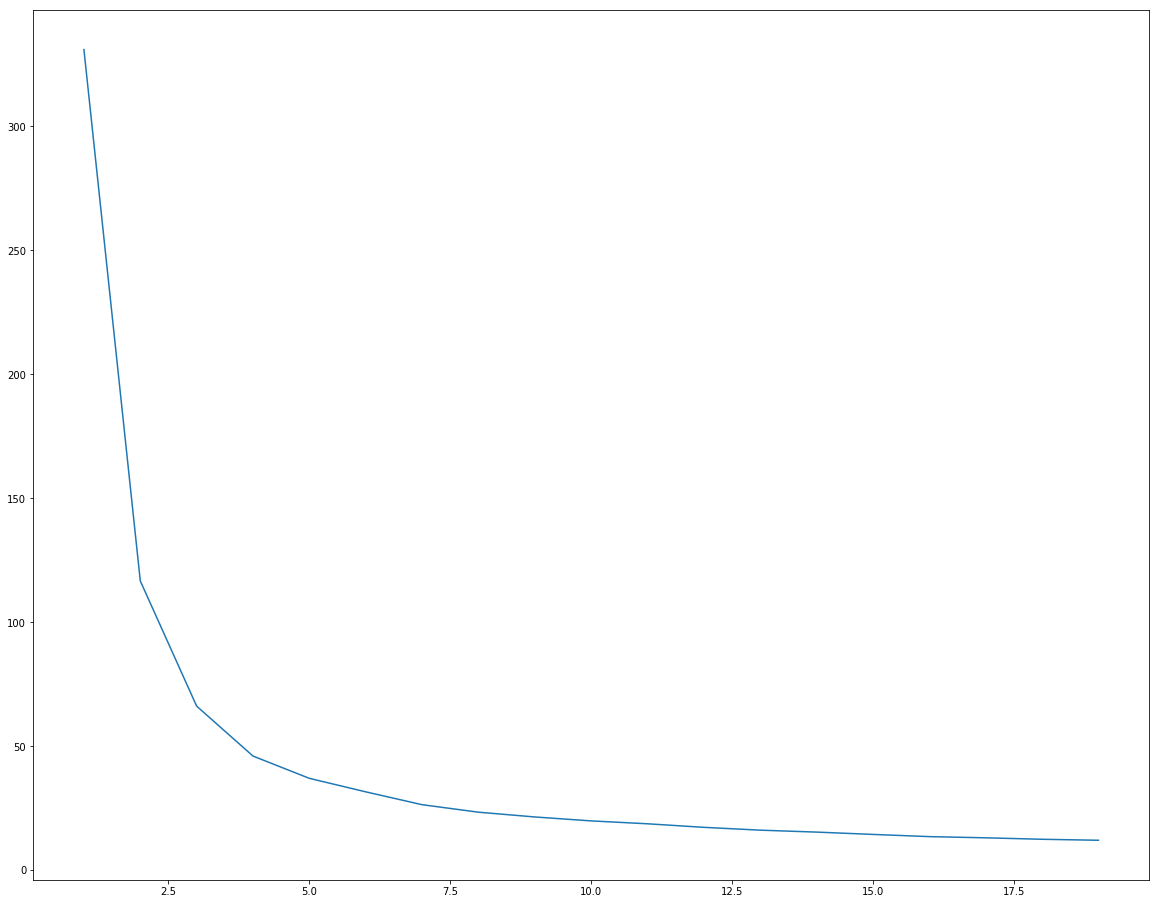

In [95]:
scale_columns = ['CustomerOrderCount',
                 'CustomerItemCount',
                 'CustomerTotalAmount', 
                 'CustomerReorderStockRate', 'CustomerReorderTransactionRate']

X = scaled_customer_profile_df[scale_columns]

k_list = []
cost_list = []
for k in range (1, 20):
    kmeans = KMeans(n_clusters=k).fit(X)
    interia = kmeans.inertia_
    print ("k:", k, "| cost:", interia)
    k_list.append(k)
    cost_list.append(interia)
plt.plot(k_list, cost_list)

In [86]:
kmeans = KMeans(n_clusters=4).fit(X)
cluster_num = kmeans.predict(X)
cluster = pd.Series(cluster_num)
scaled_customer_profile_df['cluster_num'] = cluster.values

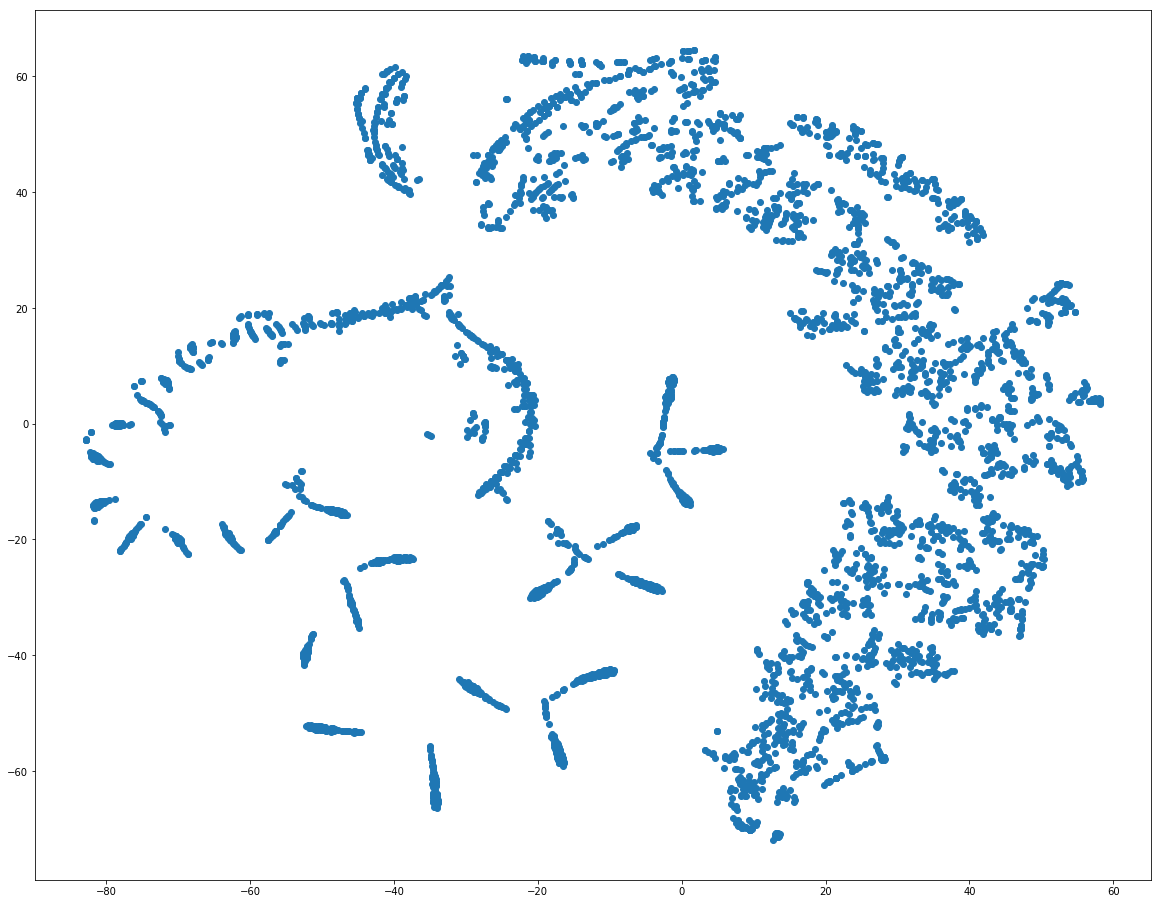

In [98]:
from sklearn.manifold import TSNE

np.random.seed(600)
model = TSNE(learning_rate=300)
transformed = model.fit_transform(X)

xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs,ys)
plt.show()

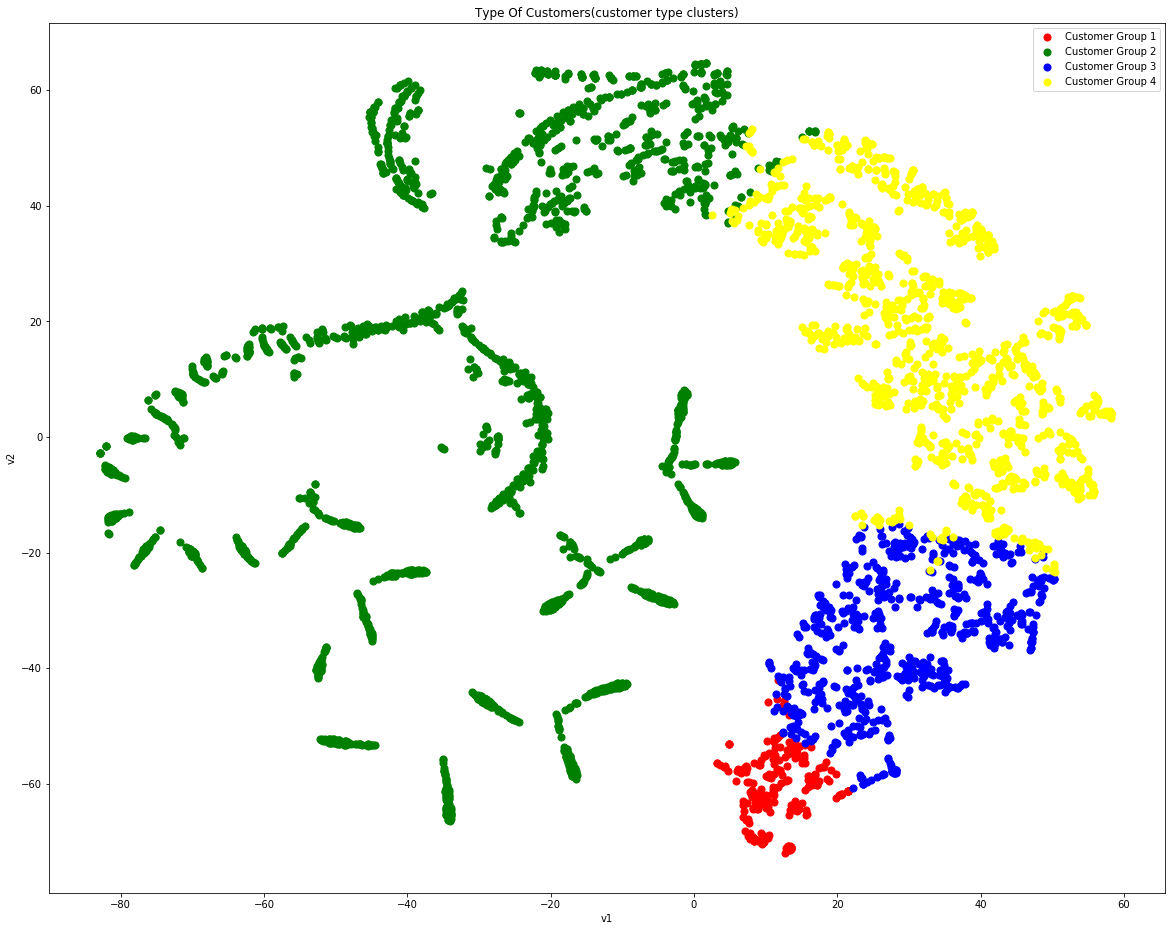

In [99]:
tsne_reduction_results = pd.DataFrame(transformed, columns=['v1', 'v2']).assign(cluster_num = scaled_customer_profile_df['cluster_num'].values)

plt.rcParams['figure.figsize'] = [20, 16]
plt.scatter(tsne_reduction_results[tsne_reduction_results['cluster_num'] == 0]['v1'], 
            tsne_reduction_results[tsne_reduction_results['cluster_num'] == 0]['v2'], 
            s = 50, c = 'red', label = 'Customer Group 1')
plt.scatter(tsne_reduction_results[tsne_reduction_results['cluster_num'] == 1]['v1'], 
            tsne_reduction_results[tsne_reduction_results['cluster_num'] == 1]['v2'], 
            s = 50, c = 'green', label = 'Customer Group 2')
plt.scatter(tsne_reduction_results[tsne_reduction_results['cluster_num'] == 2]['v1'], 
            tsne_reduction_results[tsne_reduction_results['cluster_num'] == 2]['v2'], 
            s = 50, c = 'blue', label = 'Customer Group 3')
plt.scatter(tsne_reduction_results[tsne_reduction_results['cluster_num'] == 3]['v1'], 
            tsne_reduction_results[tsne_reduction_results['cluster_num'] == 3]['v2'], 
            s = 50, c = 'yellow', label = 'Customer Group 4')
# plt.scatter(tsne_reduction_results[tsne_reduction_results['cluster_num'] == 4]['v1'], 
#             tsne_reduction_results[tsne_reduction_results['cluster_num'] == 4]['v2'], 
#             s = 50, c = 'black', label = 'Customer Group 5')
# plt.scatter(tsne_reduction_results[tsne_reduction_results['cluster_num'] == 5]['v1'], 
#             tsne_reduction_results[tsne_reduction_results['cluster_num'] == 5]['v2'], 
#             s = 50, c = 'pink', label = 'Customer Group 6')
plt.title('Type Of Customers(customer type clusters)')
plt.xlabel('v1')
plt.ylabel('v2')
plt.legend()
plt.show()

# 그룹별 분석 -> 미니퀴즈

- 시각화 결과 모양이 가장 제멋대로였던 그룹 2는, Top 10 상품에 일관성이 가장 없음.

In [88]:
scaled_customer_profile_df[['CustomerID', 'cluster_num']].head()

,CustomerID,cluster_num
61619,12346,1
148306,12347,2
34093,12348,2
485527,12349,1
80339,12350,1


In [89]:
df = pd.read_csv("../data/online_retail.csv", dtype={'CustomerID': str,'InvoiceID': str}, encoding="ISO-8859-1")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%m/%d/%Y %H:%M")

In [90]:
df = df.merge(scaled_customer_profile_df[['CustomerID', 'cluster_num']], on=['CustomerID'], how='left')

In [91]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cluster_num
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0


In [100]:
for cluster in range(0,4):
    top_10 = df[df['cluster_num']==cluster]['Description'].value_counts()
    print("cluster", str(cluster+1))
    print(top_10[:10])
    print("------\n")

cluster 1
JUMBO BAG RED RETROSPOT               466
LUNCH BAG RED RETROSPOT               393
REGENCY CAKESTAND 3 TIER              382
WHITE HANGING HEART T-LIGHT HOLDER    376
LUNCH BAG  BLACK SKULL.               324
JUMBO BAG PINK POLKADOT               272
LUNCH BAG PINK POLKADOT               269
JUMBO STORAGE BAG SUKI                268
LUNCH BAG CARS BLUE                   265
PARTY BUNTING                         254
Name: Description, dtype: int64
------

cluster 2
REGENCY CAKESTAND 3 TIER              380
WHITE HANGING HEART T-LIGHT HOLDER    320
ASSORTED COLOUR BIRD ORNAMENT         269
PARTY BUNTING                         256
SET OF 3 CAKE TINS PANTRY DESIGN      246
BAKING SET 9 PIECE RETROSPOT          229
JAM MAKING SET WITH JARS              226
POSTAGE                               219
PAPER CHAIN KIT 50'S CHRISTMAS        203
NATURAL SLATE HEART CHALKBOARD        197
Name: Description, dtype: int64
------

cluster 3
WHITE HANGING HEART T-LIGHT HOLDER    816
JUMBO BA